<a href="https://colab.research.google.com/github/luca-g97/Master-Thesis/blob/main/OLMo_(Proof_of_Concept).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The notebook doesnt run on the first try when used locally, so just select "Restart session and run all" from the Runtime rider**

In [ ]:
# @title Install Dependencies { display-mode: "form" }

!pip install -q -U datasets huggingface_hub fsspec

import joblib
import copy
import math
import time
import re
import os
import shutil
import sys
import gzip
import json
import glob
import random
import requests
import itertools
import threading
import numpy as np
from tqdm import tqdm
import scipy.sparse as sp
import torch
import torch.nn as nn
import concurrent.futures
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from concurrent.futures import ThreadPoolExecutor
from collections import Counter, defaultdict

# Compression Library Imports
import io
import pandas as pd
!pip install -q pyarrow
import pyarrow as pa
!pip install -q pyarrow-parquet
import pyarrow.parquet as pq
!pip install -q zstandard
import zstandard as zstd

# Visualization Library Imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For colormaps

# Dataset & Model Library Imports
from huggingface_hub import HfApi
!pip install -q datasets
from torch.utils.data import IterableDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset, load_from_disk, Dataset, DatasetDict, concatenate_datasets, get_dataset_config_names, get_dataset_split_names, Features, Value
from huggingface_hub.utils import HfHubHTTPError

# Third-Party Library Imports
from scipy.optimize import minimize
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import entropy, kendalltau, kurtosis, pearsonr, skew, spearmanr, wasserstein_distance

!apt-get install -y build-essential cmake liblz4-dev > /dev/null 2>&1
import lzma
!git clone https://github.com/LLNL/zfp.git > /dev/null 2>&1
!cd zfp && mkdir -p build && cd build && cmake .. > /dev/null 2>&1 && make -j > /dev/null 2>&1 && sudo make install > /dev/null 2>&1
!python3 -m pip install -q pyarrow lz4 zfpy
import zfpy

ERROR: Could not find a version that satisfies the requirement pyarrow-parquet (from versions: none)
ERROR: No matching distribution found for pyarrow-parquet
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.2/842.2 kB 30.8 MB/s eta 0:00:00


In [ ]:
# @title Import the OLMo-Model { display-mode: "form" }

os.environ["TOKENIZERS_PARALLELISM"] = "false"
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-1B-0724-hf", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("allenai/OLMo-1B-0724-hf", trust_remote_code=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

In [ ]:
# @title Structure and Information { display-mode: "form" }
layer_name_to_find = "mlp.down" #@param {type:"string"}

print(model)
layer = 0
relevantLayers = []
for actualLayer, (name, param) in enumerate(model.state_dict().items()):
    if layer_name_to_find in name:
        print(f"Layer {layer}({name}): {param.shape}")
        relevantLayers.append(actualLayer)
        layer += 1

OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb): OlmoRotaryEmbedding()
  )
  (lm_head): 

In [ ]:
# @title Output generation { display-mode: "form" }
# @markdown Enter your desired generation parameters below:
input_prompt_message = "Language modeling is" #@param {type:"string"}
max_new_tokens = 100  #@param {type:"slider", min:1, max:1000, step:1}
top_k = 1  #@param {type:"slider", min:0.0, max:1.0, step:0.01}
top_p = 0.95  #@param {type:"slider", min:0.0, max:1.0, step:0.01}

inputs = tokenizer(input_prompt_message, return_tensors='pt', return_token_type_ids=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device type: ", device)

inputs = {k: v.to(device) for k,v in inputs.items()}
model = model.to(device)
response = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True, top_k=top_k, top_p=top_p) # Top 1, max_new_tokens=1 or 2
print(tokenizer.batch_decode(response, skip_special_tokens=True)[0])

Using device type:  cpu
Language modeling is a subfield of natural language processing that studies the generation of natural language from a given context.

The task of context modeling is to generate a context-dependent natural language sentence from a given context.

The task of context modeling is to generate a context-dependent natural language sentence from a given context.

The task of context modeling is to generate a context-dependent natural language sentence from a given context.

The task of context modeling is to generate a context-dependent natural


# Dataset Overview

In [ ]:
# @title Preparation of Dolma-URLs List  { display-mode: "form" }

!git clone https://huggingface.co/datasets/allenai/dolma

!mv -v dolma/urls/v1_7.txt ./Dolma-v1_7.txt
urls = []

!rm -rf dolma

with open("./Dolma-v1_7.txt", "r") as file:
    urls = [line.strip() for line in file]

# Now, urls contains all the URLs from the file
print(urls)

Cloning into 'dolma'...
remote: Enumerating objects: 8247, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 8247 (delta 60), reused 0 (delta 0), pack-reused 8144 (from 1)
Receiving objects: 100% (8247/8247), 1.33 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (91/91), done.
renamed 'dolma/urls/v1_7.txt' -> './Dolma-v1_7.txt'
['https://olmo-data.org/dolma-v1_7/books/books-0000.json.gz', 'https://olmo-data.org/dolma-v1_7/books/books-0001.json.gz', 'https://olmo-data.org/dolma-v1_7/books/books-0002.json.gz', 'https://olmo-data.org/dolma-v1_7/c4-filtered/c4-0000.json.gz', 'https://olmo-data.org/dolma-v1_7/c4-filtered/c4-0001.json.gz', 'https://olmo-data.org/dolma-v1_7/c4-filtered/c4-0002.json.gz', 'https://olmo-data.org/dolma-v1_7/c4-filtered/c4-0003.json.gz', 'https://olmo-data.org/dolma-v1_7/c4-filtered/c4-0004.json.gz', 'https://olmo-data.org/dolma-v1_7/c4-filtered/c4-0005.json.gz', 'https://olmo-data.org/dolma-v1_7/

In [ ]:
# @title Done: Creation of Dataset for HuggingFace  { display-mode: "form" }

# # Define paths
# base_dir = "./datasets/"
# os.makedirs(base_dir, exist_ok=True)  # Ensure temp directory exists

# progress_file = os.path.join(base_dir, "progress.json")
# completed_files_file = os.path.join(base_dir, "completed_files.json")

# # Define token targets
# target_tokens = {
#     "algebraic-stack-train": int(3.5e9),
#     "c4": int(4.4e9),
#     "falcon": int(4.4e9),
#     "open-web-math-train": int(6.2e9),
#     "pes2o": int(3.3e9),
#     "reddit": int(4.6e9),
#     "stackexchange": int(5.6e9),
#     "starcoder": int(5.6e9),
#     "tulu_flan": int(8.0e9),
#     "wiki": int(1.8e9),
#     "books": int(2.6e9)
# }

# # Load previous progress if available
# if os.path.exists(progress_file):
#     with open(progress_file, "r") as f:
#         collected_tokens = json.load(f)
# else:
#     collected_tokens = {source: 0 for source in target_tokens}

# # Load completed files to avoid re-downloading
# if os.path.exists(completed_files_file):
#     with open(completed_files_file, "r") as f:
#         completed_files = json.load(f)
# else:
#     completed_files = {}

# # Function to get the source from a URL
# def get_source_from_url(url):
#     for source in target_tokens.keys():
#         if f"{source}" in url:
#             return source
#     return None

# def append_to_jsonl(file_path, examples):
#     with open(file_path, "a", encoding="utf-8") as f:  # 'a' for append mode
#         for example in examples:
#             f.write(json.dumps(example) + "\n")

# # Function to download and process a single file with a progress bar
# def process_file(url, source):
#     global collected_tokens

#     file_name = url.split("/")[-1]
#     file_path = os.path.join(base_dir, file_name)

#     # Skip if target already reached or file is processed
#     if collected_tokens[source] >= target_tokens[source] or file_name in completed_files.keys():
#         return []

#     # Download file with a progress bar
#     response = requests.get(url, stream=True)
#     if response.status_code == 200:
#         total_size = int(response.headers.get('Content-Length', 0))
#         with open(file_path, "wb") as f, tqdm(total=total_size, unit="B", unit_scale=True, desc=file_name) as pbar:
#             for chunk in response.iter_content(chunk_size=8192):
#                 if chunk:
#                     f.write(chunk)
#                     pbar.update(len(chunk))
#     else:
#         print(f"Failed to download {url}")
#         return []

#     # Count total lines in file
#     with gzip.open(file_path, "rt", encoding="utf-8") as f:
#         total_lines = sum(1 for _ in f)
#         print("Total Lines: ", total_lines)

#     # Read and process the gzipped file
#     processed_lines = 0
#     included_tokens = 0
#     examples = []
#     with gzip.open(file_path, "rt", encoding="utf-8") as f:
#         for line in f:
#             data = json.loads(line)
#             text = data.get("text", "")
#             token_count = len(tokenizer(text)["input_ids"])

#             # If adding this document would exceed the target, stop processing this file
#             if collected_tokens[source] + token_count >= target_tokens[source]:
#                 collected_tokens[source] = target_tokens[source]
#                 break
#             else:
#                 collected_tokens[source] += token_count
#                 included_tokens += token_count
#                 examples.append(data)
#                 processed_lines += 1

#     os.remove(file_path)  # Cleanup downloaded file

#     # Save completed file status with percentage
#     completed_files[file_name] = completed_files[file_name] = {
#     "included_percentage": (processed_lines / total_lines) * 100 if total_lines > 0 else 100,
#     "included_tokens": included_tokens
#     }

#     # Save progress and list of completed files
#     with open(progress_file, "w") as f:
#         json.dump(collected_tokens, f, indent=4)
#     with open(completed_files_file, "w") as f:
#         json.dump(completed_files, f, indent=4)

#     return examples

# Process files incrementally for each source
# for url in urls:
#     source = get_source_from_url(url)
#     source_name = url.split("/")[-1].split(".json.gz")[0]
#     if source and collected_tokens[source] < target_tokens[source]:
#         examples = process_file(url, source)
#         append_to_jsonl(os.path.join(base_dir, f"{source_name}.jsonl"), examples)
#         print(f"{source}: Collected {collected_tokens[source]} tokens for source '{source_name}'")
#     elif source and collected_tokens[source] >= target_tokens[source]:
#         print(f"{source}: Skipping '{source_name}' due to already reached token count")
#     else:
#         print(f"{source}: Skipping '{source_name}' -> '{url}' not included")

In [ ]:
# @title Done: Preprocessing of files for Dataset on HuggingFace  { display-mode: "form" }

# hf_repo = "luca-g97/dolma-v1_7-50B-phase2"  # Change to your Hugging Face dataset name

# source_splits = {}

# # Find all JSONL files in the base directory
# source_files = glob.glob(os.path.join(base_dir, "*.jsonl"))

# print(source_files)

# # Upload dataset metadata only
# for file_path in source_files:
#     file_name = os.path.basename(file_path).replace(".jsonl", "")  # Extract 'books-0000'
#     source_name = file_name.split("-")[0]  # Extract 'books' from 'books-0000'

#     # Store metadata (we don't load the full dataset to avoid memory issues)
#     source_splits[file_name] = {"path": file_path, "source": source_name}

# # Save metadata as a JSON file
# with open("dataset_metadata.json", "w") as f:
#     json.dump(source_splits, f, indent=4)

In [ ]:
#@title Done: Special Preparation (Only necessary for 5 sources) { display-mode: "form" }

# def flatten_dict(d, parent_key='', sep='_'):
#     """
#     Recursively flatten a nested dictionary.
#     Lists are handled by converting them to JSON strings.
#     """
#     items = []
#     for k, v in d.items():
#         new_key = f"{parent_key}{sep}{k}" if parent_key else k
#         if isinstance(v, dict):
#             items.extend(flatten_dict(v, new_key, sep=sep).items())
#         elif isinstance(v, list):
#             # Convert lists to JSON strings to preserve structure
#             items.append((new_key, json.dumps(v)))
#         else:
#             items.append((new_key, v))
#     return dict(items)

# def enforce_column_types(entries, column_types):
#     """
#     Ensure all entries match the inferred column type.
#     """
#     for entry in entries:
#         for key in list(entry.keys()):
#             if key not in column_types:
#                 continue
#             expected_type = column_types[key]
#             value = entry[key]

#             # Handle None values (already handled by defaults)
#             if value is None:
#                 continue

#             # Convert to expected type
#             try:
#                 if expected_type == str:
#                     if not isinstance(value, str):
#                         entry[key] = str(value)
#                 elif expected_type == int:
#                     entry[key] = int(value)
#                 elif expected_type == float:
#                     entry[key] = float(value)
#                 elif expected_type == bool:
#                     entry[key] = bool(value)
#             except (ValueError, TypeError):
#                 # Fallback to string if conversion fails
#                 entry[key] = str(value)
#     return entries

# def process_jsonl_file(input_path, output_path):
#     """
#     Process a JSONL file:
#       1. Flatten each JSON object.
#       2. Collect union of all keys and infer each key's type.
#       3. Write out a new JSONL file where every entry has every key,
#          filling missing values with a default based on type.

#     Returns the sorted list of keys.
#     """
#     entries = []
#     all_keys = set()
#     column_types = {}

#     # First pass: Collect types and keys
#     with open(input_path, "r", encoding="utf-8") as infile:
#         for line_num, line in enumerate(infile, 1):
#             if not line.strip():
#                 continue
#             try:
#                 data = json.loads(line)
#                 flat_entry = flatten_dict(data)
#                 entries.append(flat_entry)
#                 all_keys.update(flat_entry.keys())

#                 # Update column types
#                 for k, v in flat_entry.items():
#                     if v is None:
#                         continue
#                     observed_type = type(v)
#                     if k not in column_types:
#                         column_types[k] = observed_type
#                     else:
#                         if column_types[k] != observed_type:
#                             # Resolve conflicts by converting to string
#                             column_types[k] = str
#             except Exception as e:
#                 print(f"Error in line {line_num}: {e}")
#                 continue

#     # Set default type for keys without values
#     for k in all_keys:
#         if k not in column_types:
#             column_types[k] = str

#     # Enforce consistent types across all entries
#     entries = enforce_column_types(entries, column_types)

#     # Generate defaults based on finalized types
#     column_defaults = {
#         k: "" if t == str else 0 if t == int else 0.0 if t == float else False if t == bool else None
#         for k, t in column_types.items()
#     }

#     # Second pass: Write consistent data
#     sorted_keys = sorted(all_keys)
#     with open(output_path, "w", encoding="utf-8") as outfile:
#         for entry in entries:
#             full_entry = {
#                 k: entry.get(k, column_defaults[k])
#                 if entry.get(k) is not None  # Handle missing keys
#                 else column_defaults[k]
#                 for k in sorted_keys
#             }
#             outfile.write(json.dumps(full_entry) + "\n")

#     return sorted_keys

# # --- Main processing for the missing subsets ---

# # Define your base path where your JSONL files are stored.
# base_path = "/tf/datasets"  # Adjust to your directory

# # List of subsets (without extension) you want to update.
# missing_subsets = [
#     "books-0000",
#     "algebraic-stack-train-0000",
#     "algebraic-stack-train-0001",
#     "open-web-math-train-0003",
#     "open-web-math-train-0005"
# ]

# for subset in missing_subsets:
#     input_file = os.path.join(base_path, f"{subset}.jsonl")
#     output_file = os.path.join(base_path, f"processed_{subset}.jsonl")
#     if not os.path.exists(input_file):
#         print(f"Input file not found: {input_file}")
#         continue
#     print(f"Processing {input_file}...")
#     keys = process_jsonl_file(input_file, output_file)
#     print(f"Processed {subset} with {len(keys)} columns.")
#     # Replace the original file with the processed file.
#     try:
#         os.remove(input_file)
#         os.rename(output_file, input_file)
#         print(f"Replaced {input_file} with processed version.")
#     except Exception as e:
#         print(f"Error replacing file {input_file}: {e}")

# print("All files processed successfully.")

In [ ]:
# @title Done: Repository Creation on Huggingface  { display-mode: "form" }

# api = HfApi()
# repo_name = "luca-g97/dolma-v1_7-50B-second-phase"  # Ensure the repo name is correct and follows your Hugging Face username/repository-name format

# Create the dataset repo if it doesn't exist
#api.create_repo(repo_id=repo_name, repo_type="dataset", private=False)  # Set private=True if it's a private dataset

In [ ]:
# @title Done: Upload Dataset on HuggingFace { display-mode: "form" }

# #Upload each file in the source_files list
# for file_path in source_files:
#     file_name = os.path.basename(file_path)  # Extract the file name (e.g., books-0000.jsonl)

#     # Upload the file to the Hugging Face repo
#     api.upload_file(
#         path_or_fileobj=file_path,  # Path to the .jsonl file
#         path_in_repo=file_name,  # Upload the file with its original name
#         repo_id=repo_name,
#         repo_type="dataset",
#         token=True  # Ensure you're authenticated with the correct token
#     )

In [ ]:
# @title Done: Metadata-Upload for HuggingFace  { display-mode: "form" }

# #Upload the metadata file (e.g., dataset_metadata.json or similar)
# api.upload_file(path_or_fileobj="dataset_metadata.json", path_in_repo="dataset_metadata.json", repo_id=repo_name,  repo_type="dataset")

In [ ]:
# @title Streaming uploaded files from HuggingFace Dataset { display-mode: "form" }

dataset_splits = get_dataset_split_names("luca-g97/dolma-v1_7-50B-second-phase")
print("Dataset Splits:", dataset_splits)

# Load the full dataset
full_dataset = load_dataset("luca-g97/dolma-v1_7-50B-second-phase", streaming=True)

# Load a merged source split -> e.g. 'books'
books_dataset = load_dataset("luca-g97/dolma-v1_7-50B-second-phase", "books", streaming=True)

# Load a individual file split -> e.g. 'books-0001'
books_0001 = load_dataset("luca-g97/dolma-v1_7-50B-second-phase", "books-0001")

# Load a specific subsource and retrieve the first 10 entries
dataset = load_dataset("luca-g97/dolma-v1_7-50B-second-phase","books-0001",
    split="train", # Directly download only the train split (containing all files anyway)
    download_mode="reuse_dataset_if_exists",  # Avoid re-downloading if files exist
    streaming=True  # Stream data instead of loading it all into memory
)
books_0001_sample = dataset.take(10)  # Take only the first 10 examples
print(list(books_0001_sample)) # Print only the partly loaded dataset

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Dataset Splits: ['train']


Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

books-0001.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

[{'added': '2023-04-25T05:49:59.881Z', 'created': '2014-05-03T00:00:00.000Z', 'id': 'd1e9611bce982029833e70484086f28315493c05', 'metadata': {'gutenberg_metadata_available': True, 'issued_or_updated_available': True, 'length': 10668, 'pipeline': 'gutenbergpy', 'provenance': 'books-0001.json.gz:1', 'purl.org/dc/terms/issued': datetime.datetime(2014, 5, 3, 0, 0), 'purl.org/dc/terms/publisher': 'Project Gutenberg', 'purl.org/dc/terms/rights': 'Public domain in the USA.', 'purl.org/dc/terms/title': 'Old Irish Glass', 'rdf_available': True, 'www.gutenberg.org/2009/pgterms/downloads': 27, 'www.gutenberg.org/2009/pgterms/marc901': 'file:///public/vhost/g/gutenberg/html/files/45570/45570-h/images/cover.jpg'}, 'source': 'gutenberg', 'text': 'THE CONNOISSEUR SERIES\n    OF BOOKS FOR COLLECTORS\n\n    OLD IRISH GLASS\n\n\nPLATE I.\n\n[Illustration:\n\n  CARD OF MEMBERSHIP OF THE CORK\n  GLASS-CUTTERS\' UNION.\n   _In the possession of the Author._]\n\n\n  THE CONNOISSEUR SERIES OF BOOKS FOR COLLEC

# Data Evaluation

In [ ]:
# @title Done: Dataset-Download for Evaluation  { display-mode: "form" }

# # Get all available subsets (configurations)
# subsets = get_dataset_config_names("luca-g97/dolma-v1_7-50B-second-phase")
# print("Dataset Subsets:", subsets)

# # Filter sources that contain "-00"
# sources = [source for source in subsets if "-00" in source]
# print("Subsets:", sources)

# # Define a function to check and save the dataset
# def download_and_save(source):
#     save_directory = f"./Dolma-Datasets/{source}"

#     # Check if the dataset is already downloaded
#     if os.path.exists(save_directory):
#         print(f"Dataset {source} already exists. Skipping download.")
#     else:
#         print(f"Downloading and saving {source}...")
#         # Load the dataset
#         dataset = load_dataset("luca-g97/dolma-v1_7-50B-second-phase", source, split="train")

#         # Save the dataset to disk
#         dataset.save_to_disk(save_directory)
#         print(f"Dataset {source} saved to {save_directory}")

# # Use ThreadPoolExecutor for parallel downloading
# with ThreadPoolExecutor() as executor:
#     executor.map(download_and_save, sources)

# print("Download and saving process completed.")

In [ ]:
# @title Done: Subset Range Preparation for Evaluation { display-mode: "form" }

# Define the dataset root directory
dataset_root = "./Dolma-Datasets"

# # Iterate over all subset folders
# subset_counts = {}
# for subset in os.listdir(dataset_root):
#     if(subset != "Evaluation"):
#         subset_path = os.path.join(dataset_root, subset)

#         # Ensure it's a directory
#         if os.path.isdir(subset_path):
#             try:
#                 # Load dataset
#                 dataset = load_from_disk(subset_path)

#                 # Count records
#                 num_records = len(dataset)
#                 subset_counts[subset] = num_records
#                 print(f"{subset}: {num_records} records")
#             except Exception as e:
#                 print(f"Error loading {subset}: {e}")

subset_counts = {'books-0001': 1, 'open-web-math-train-0005': 17767, 'algebraic-stack-train-0000': 77494, 'algebraic-stack-train-0001': 71967, 'open-web-math-train-0003': 75196, 'open-web-math-train-0006': 82493, 'books-0000': 48716, 'open-web-math-train-0004': 247325, 'open-web-math-train-0002': 247365, 'algebraic-stack-train-0002': 396232, 'stackexchange-0000': 1214081, 'open-web-math-train-0000': 498708, 'open-web-math-train-0001': 498742, 'stackexchange-0001': 1336727, 'stackexchange-0002': 1290587, 'falcon-0004': 1042373, 'reddit-0004': 1765711, 'falcon-0003': 1350382, 'falcon-0002': 1354843, 'falcon-0000': 1357534, 'c4-0002': 1548258, 'falcon-0001': 1349288, 'c4-0001': 1551162, 'c4-0003': 1551422, 'c4-0000': 1551326, 'c4-0004': 1549652, 'pes2o-0003': 801259, 'reddit-0003': 5143921, 'reddit-0000': 5093082, 'reddit-0002': 5296647, 'reddit-0001': 5252593, 'stackexchange-0004': 977112, 'stackexchange-0003': 1107854, 'stackexchange-0005': 1147708, 'stackexchange-0007': 655867, 'stackexchange-0006': 1143151, 'tulu_flan-0000': 703233, 'starcoder-0000': 4864607, 'tulu_flan-0001': 499772, 'tulu_flan-0003': 799883, 'tulu_flan-0002': 699838, 'tulu_flan-0005': 799937, 'tulu_flan-0004': 999952, 'tulu_flan-0006': 899970, 'tulu_flan-0007': 899990, 'tulu_flan-0009': 454506, 'tulu_flan-0011': 399820, 'tulu_flan-0010': 399817, 'tulu_flan-0008': 899985, 'tulu_flan-0015': 599913, 'tulu_flan-0012': 399797, 'tulu_flan-0013': 499762, 'tulu_flan-0014': 599918, 'tulu_flan-0016': 499921, 'tulu_flan-0017': 699928, 'tulu_flan-0018': 799965, 'tulu_flan-0019': 799962, 'tulu_flan-0020': 799964, 'tulu_flan-0021': 919526, 'tulu_flan-0023': 2151466, 'tulu_flan-0022': 1502544, 'tulu_flan-0024': 1926695, 'tulu_flan-0025': 1404371, 'tulu_flan-0028': 748972, 'tulu_flan-0026': 2128463, 'tulu_flan-0029': 698854, 'tulu_flan-0027': 2156616, 'tulu_flan-0031': 34863, 'pes2o-0002': 3875989, 'pes2o-0000': 3862532, 'pes2o-0001': 3876670, 'tulu_flan-0030': 698828, 'wiki-0000': 1980823}
print("Subset file counts:", subset_counts)

Subset file counts: {'books-0001': 1, 'open-web-math-train-0005': 17767, 'algebraic-stack-train-0000': 77494, 'algebraic-stack-train-0001': 71967, 'open-web-math-train-0003': 75196, 'open-web-math-train-0006': 82493, 'books-0000': 48716, 'open-web-math-train-0004': 247325, 'open-web-math-train-0002': 247365, 'algebraic-stack-train-0002': 396232, 'stackexchange-0000': 1214081, 'open-web-math-train-0000': 498708, 'open-web-math-train-0001': 498742, 'stackexchange-0001': 1336727, 'stackexchange-0002': 1290587, 'falcon-0004': 1042373, 'reddit-0004': 1765711, 'falcon-0003': 1350382, 'falcon-0002': 1354843, 'falcon-0000': 1357534, 'c4-0002': 1548258, 'falcon-0001': 1349288, 'c4-0001': 1551162, 'c4-0003': 1551422, 'c4-0000': 1551326, 'c4-0004': 1549652, 'pes2o-0003': 801259, 'reddit-0003': 5143921, 'reddit-0000': 5093082, 'reddit-0002': 5296647, 'reddit-0001': 5252593, 'stackexchange-0004': 977112, 'stackexchange-0003': 1107854, 'stackexchange-0005': 1147708, 'stackexchange-0007': 655867, 'st

In [ ]:
# @title Done: Range Calculation for Evaluation { display-mode: "form" }

# # Sort subsets alphabetically
# sorted_subsets = sorted(subset_counts.keys())

# # Compute start and end index ranges
# cumulative_count = 0
# subset_ranges = {}

# for sourceNumber, subset in enumerate(sorted_subsets):
#     start_idx = cumulative_count
#     end_idx = start_idx + subset_counts[subset] - 1  # End index is inclusive
#     subset_ranges[subset] = (sourceNumber, start_idx, end_idx)
#     cumulative_count = end_idx + 1  # Next subset starts after the last end index

# # Print results
# for (subset, (source, start, end)) in subset_ranges.items():
#     print(f"{subset}({source}): {start} -> {end}")

subset_ranges = {'algebraic-stack-train-0000': (0, 0, 77493), 'algebraic-stack-train-0001': (1, 77494, 149460), 'algebraic-stack-train-0002': (2, 149461, 545692), 'books-0000': (3, 545693, 594408), 'books-0001': (4, 594409, 594409), 'c4-0000': (5, 594410, 2145735), 'c4-0001': (6, 2145736, 3696897), 'c4-0002': (7, 3696898, 5245155), 'c4-0003': (8, 5245156, 6796577), 'c4-0004': (9, 6796578, 8346229), 'falcon-0000': (10, 8346230, 9703763), 'falcon-0001': (11, 9703764, 11053051), 'falcon-0002': (12, 11053052, 12407894), 'falcon-0003': (13, 12407895, 13758276), 'falcon-0004': (14, 13758277, 14800649), 'open-web-math-train-0000': (15, 14800650, 15299357), 'open-web-math-train-0001': (16, 15299358, 15798099), 'open-web-math-train-0002': (17, 15798100, 16045464), 'open-web-math-train-0003': (18, 16045465, 16120660), 'open-web-math-train-0004': (19, 16120661, 16367985), 'open-web-math-train-0005': (20, 16367986, 16385752), 'open-web-math-train-0006': (21, 16385753, 16468245), 'pes2o-0000': (22, 16468246, 20330777), 'pes2o-0001': (23, 20330778, 24207447), 'pes2o-0002': (24, 24207448, 28083436), 'pes2o-0003': (25, 28083437, 28884695), 'reddit-0000': (26, 28884696, 33977777), 'reddit-0001': (27, 33977778, 39230370), 'reddit-0002': (28, 39230371, 44527017), 'reddit-0003': (29, 44527018, 49670938), 'reddit-0004': (30, 49670939, 51436649), 'stackexchange-0000': (31, 51436650, 52650730), 'stackexchange-0001': (32, 52650731, 53987457), 'stackexchange-0002': (33, 53987458, 55278044), 'stackexchange-0003': (34, 55278045, 56385898), 'stackexchange-0004': (35, 56385899, 57363010), 'stackexchange-0005': (36, 57363011, 58510718), 'stackexchange-0006': (37, 58510719, 59653869), 'stackexchange-0007': (38, 59653870, 60309736), 'starcoder-0000': (39, 60309737, 65174343), 'tulu_flan-0000': (40, 65174344, 65877576), 'tulu_flan-0001': (41, 65877577, 66377348), 'tulu_flan-0002': (42, 66377349, 67077186), 'tulu_flan-0003': (43, 67077187, 67877069), 'tulu_flan-0004': (44, 67877070, 68877021), 'tulu_flan-0005': (45, 68877022, 69676958), 'tulu_flan-0006': (46, 69676959, 70576928), 'tulu_flan-0007': (47, 70576929, 71476918), 'tulu_flan-0008': (48, 71476919, 72376903), 'tulu_flan-0009': (49, 72376904, 72831409), 'tulu_flan-0010': (50, 72831410, 73231226), 'tulu_flan-0011': (51, 73231227, 73631046), 'tulu_flan-0012': (52, 73631047, 74030843), 'tulu_flan-0013': (53, 74030844, 74530605), 'tulu_flan-0014': (54, 74530606, 75130523), 'tulu_flan-0015': (55, 75130524, 75730436), 'tulu_flan-0016': (56, 75730437, 76230357), 'tulu_flan-0017': (57, 76230358, 76930285), 'tulu_flan-0018': (58, 76930286, 77730250), 'tulu_flan-0019': (59, 77730251, 78530212), 'tulu_flan-0020': (60, 78530213, 79330176), 'tulu_flan-0021': (61, 79330177, 80249702), 'tulu_flan-0022': (62, 80249703, 81752246), 'tulu_flan-0023': (63, 81752247, 83903712), 'tulu_flan-0024': (64, 83903713, 85830407), 'tulu_flan-0025': (65, 85830408, 87234778), 'tulu_flan-0026': (66, 87234779, 89363241), 'tulu_flan-0027': (67, 89363242, 91519857), 'tulu_flan-0028': (68, 91519858, 92268829), 'tulu_flan-0029': (69, 92268830, 92967683), 'tulu_flan-0030': (70, 92967684, 93666511), 'tulu_flan-0031': (71, 93666512, 93701374), 'wiki-0000': (72, 93701375, 95682197)}
print(subset_ranges)

{'algebraic-stack-train-0000': (0, 0, 77493), 'algebraic-stack-train-0001': (1, 77494, 149460), 'algebraic-stack-train-0002': (2, 149461, 545692), 'books-0000': (3, 545693, 594408), 'books-0001': (4, 594409, 594409), 'c4-0000': (5, 594410, 2145735), 'c4-0001': (6, 2145736, 3696897), 'c4-0002': (7, 3696898, 5245155), 'c4-0003': (8, 5245156, 6796577), 'c4-0004': (9, 6796578, 8346229), 'falcon-0000': (10, 8346230, 9703763), 'falcon-0001': (11, 9703764, 11053051), 'falcon-0002': (12, 11053052, 12407894), 'falcon-0003': (13, 12407895, 13758276), 'falcon-0004': (14, 13758277, 14800649), 'open-web-math-train-0000': (15, 14800650, 15299357), 'open-web-math-train-0001': (16, 15299358, 15798099), 'open-web-math-train-0002': (17, 15798100, 16045464), 'open-web-math-train-0003': (18, 16045465, 16120660), 'open-web-math-train-0004': (19, 16120661, 16367985), 'open-web-math-train-0005': (20, 16367986, 16385752), 'open-web-math-train-0006': (21, 16385753, 16468245), 'pes2o-0000': (22, 16468246, 20330

In [ ]:
# @title Dataset-Classes Initialization  { display-mode: "form" }

class GiantIterableDataset(IterableDataset):
    def __init__(self, dataset, size, tokenizer, max_model_length=512):
        self.dataset = dataset
        self.dataset_size = size
        self.tokenizer = tokenizer
        self.max_model_length = max_model_length

    def __iter__(self):
        chunk_size = self.max_model_length - self.tokenizer.num_special_tokens_to_add(pair=False)

        for example in self.dataset:
            text = example.get('text', '') or ''

            tokenized = self.tokenizer(
                text,
                add_special_tokens=False,
                truncation=False,
                return_attention_mask=False,
                return_token_type_ids=False,
            )
            input_ids = tokenized["input_ids"]

            # Skip any documents that produce no tokens after tokenization
            if not input_ids:
                continue

            # --- FIX: Take only the first chunk to truncate the document ---
            first_chunk = input_ids[:chunk_size]

            # The rest of the logic now operates only on this first chunk
            chunk_with_specials = self.tokenizer.build_inputs_with_special_tokens(first_chunk)
            attention_mask = [1] * len(chunk_with_specials)
            pad_length = self.max_model_length - len(chunk_with_specials)

            if pad_length > 0:
                padded_input_ids = chunk_with_specials + [self.tokenizer.pad_token_id] * pad_length
                padded_attention_mask = attention_mask + [0] * pad_length
            else:
                padded_input_ids = chunk_with_specials[:self.max_model_length]
                padded_attention_mask = attention_mask[:self.max_model_length]

            yield {
                "input_ids": torch.tensor(padded_input_ids),
                "attention_mask": torch.tensor(padded_attention_mask)
            }

def create_streaming_dataloader(dataset_name, batch_size=1, max_model_length=1024,
                              size=None, random_sample=False, shuffle_buffer_size=1000):
    dataset_path = os.path.join(dataset_root, dataset_name)

    if not os.path.exists(dataset_path):
        dataset = load_dataset("luca-g97/dolma-v1_7-50B-second-phase", dataset_name,
             split="train", download_mode="reuse_dataset_if_exists", streaming=True)
    else:
        dataset = load_from_disk(dataset_path)
    dataset = dataset.take(size)

    # Initialize base dataset
    base_dataset = GiantIterableDataset(
        dataset=dataset,
        size=size,
        tokenizer=tokenizer,
        max_model_length=max_model_length
    )

    class SizedDataset(IterableDataset):
        def __init__(self, dataset, size, random_sample, shuffle_buffer_size=1000):
            self.dataset = dataset
            self.target_size = size
            self.random_sample = random_sample
            self.shuffle_buffer_size = shuffle_buffer_size

        def __iter__(self):
            worker_info = torch.utils.data.get_worker_info()
            if worker_info is None:  # Single-process data loading
                num_workers = 1
                worker_id = 0
            else:  # Distributed among multiple workers
                num_workers = worker_info.num_workers
                worker_id = worker_info.id

            # Calculate per-worker target size
            per_worker = self.target_size // num_workers
            remainder = self.target_size % num_workers
            if worker_id < remainder:
                per_worker += 1
            worker_target_size = per_worker

            if self.random_sample:
                return self._random_iter(worker_target_size)
            else:
                return self._sequential_iter(worker_target_size)

        def _sequential_iter(self, worker_target_size):
            count = 0
            for item in self.dataset:
                if count >= worker_target_size:
                    break
                yield item
                count += 1

        def _random_iter(self, worker_target_size):
            buffer = []
            total_yielded = 0
            for item in self.dataset:
                buffer.append(item)
                # Fill buffer to min(worker_target_size, self.shuffle_buffer_size)
                if len(buffer) < min(worker_target_size, self.shuffle_buffer_size):
                    continue

                # Determine how many to yield from the buffer
                yield_count = min(len(buffer), worker_target_size - total_yielded)
                if yield_count <= 0:
                    break

                # Randomly sample and yield
                samples = random.sample(buffer, yield_count)
                yield from samples
                total_yielded += yield_count

                # Remove yielded samples from buffer
                # (since random.sample picks without replacement)
                # We need to rebuild buffer excluding the sampled items
                # However, since we sampled all buffer items, we reset it
                buffer = []

            # Handle remaining items in buffer if needed
            if buffer and total_yielded < worker_target_size:
                remaining = worker_target_size - total_yielded
                yield from random.sample(buffer, min(remaining, len(buffer)))

    # Wrap dataset if size is specified
    if size is not None:
        if(size > base_dataset.dataset_size):
            size = base_dataset.dataset_size
        dataset = SizedDataset(base_dataset, size, random_sample)
    else:
        dataset = base_dataset

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1, # Has to be one to not introduce errors within the eval_dataloader
        pin_memory=True
    )

def create_eval_dataloader(contexts, batch_size, tokenizer):
    eval_dataset = Dataset.from_list([{"text": text} for text in contexts])
    iterable_dataset = GiantIterableDataset(eval_dataset, len(contexts), tokenizer)
    return DataLoader(iterable_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)

def create_combined_dataloader(subset_names, batch_size, samples_per_subset, tokenizer, max_model_length=1024):
    """
    Loads multiple training subsets, combines them, and returns a single DataLoader.
    """
    all_datasets = []
    print("Loading and combining all training subsets...")

    unified_features = Features({'text': Value('string')})
    def enforce_schema(example):
        return {'text': str(example.get('text', '') or '')}

    for name in tqdm(subset_names, desc="Loading subsets"):
        retries = 3
        while retries > 0:
            try:
                num_samples = 1 if name == 'books-0001' else samples_per_subset
                dataset = load_dataset("luca-g97/dolma-v1_7-50B-second-phase", name, split="train", streaming=True).take(num_samples)
                dataset = dataset.map(enforce_schema, features=unified_features)
                all_datasets.append(dataset)
                # Success, so we break the retry loop
                break
            except HfHubHTTPError as e:
                # Check if it's the specific rate-limiting error
                if e.response.status_code == 429 and retries > 0:
                    wait_time = 5 * (4 - retries) # Wait 5, 10, then 15 seconds
                    print(f"\nRate limit hit for '{name}'. Waiting {wait_time} seconds to retry...")
                    time.sleep(wait_time)
                    retries -= 1
                else:
                    # It's a different error, or we're out of retries
                    print(f"\nSkipping subset '{name}' due to unrecoverable error: {e}")
                    break
            except Exception as e:
                print(f"\nSkipping subset '{name}' due to a general error: {e}")
                break

    if not all_datasets:
        raise ValueError("Loading failed for all datasets.")

    print("\nCombining datasets into a single data stream...")
    # Concatenate all the individual iterable datasets into one
    combined_dataset = concatenate_datasets(all_datasets)

    # Wrap the combined dataset in our custom class that handles tokenization and chunking
    iterable_dataset = GiantIterableDataset(
        dataset=combined_dataset,
        size=len(all_datasets) * samples_per_subset, # This is an approximation
        tokenizer=tokenizer,
        max_model_length=max_model_length
    )

    return DataLoader(
        iterable_dataset,
        batch_size=batchSize,
        num_workers=1,
        pin_memory=True
    )

In [ ]:
# @title Storage-Compression Initialization  { display-mode: "form" }

def create_true_intrinsic_representative(vector):
    vector = np.asarray(vector, dtype=float)
    if vector.size < 2: return np.full(11, np.nan)
    return np.array([
        np.mean(vector), np.std(vector), skew(vector), kurtosis(vector),
        np.linalg.norm(vector, ord=2), np.linalg.norm(vector, ord=1),
        np.count_nonzero(np.abs(vector) > 1e-6) / vector.size,
        np.linalg.norm(vector, ord=1) / (np.linalg.norm(vector, ord=2) + 1e-9),
        np.ptp(vector), np.percentile(vector, 75) - np.percentile(vector, 25),
        np.median(vector)
    ])

# Normalize function to convert to integer range for sparse arrays
# --- Helper functions for SparseNormCompressor ---
def normalize_to_integer_sparse(sparse_data, min_val, max_val, rate=16):
    min_int, max_int = 0, 2**rate - 1; dtype = np.uint8 if rate == 8 else np.uint16
    if min_val == max_val: return sp.coo_matrix(sparse_data.shape, dtype=dtype)
    scale = (max_int - min_int) / (max_val - min_val)
    shift = min_int - min_val * scale
    sparse_data = sparse_data.tocoo()
    normalized_data = sparse_data.copy()
    normalized_data.data = np.clip(np.round(normalized_data.data * scale + shift), min_int, max_int).astype(dtype)
    return normalized_data

def denormalize_from_integer_sparse(data, min_val, max_val, rate=16):
    min_int, max_int = 0, 2**rate - 1
    if min_val == max_val: return np.full(data.shape, min_val, dtype=np.float32)
    scale = (max_val - min_val) / (max_int - min_int)
    shift = min_val - min_int * scale
    denormalized_data = data.astype(np.float32)
    denormalized_data.data = denormalized_data.data * scale + shift
    return denormalized_data.toarray().squeeze()

# --- Compression Method Wrappers ---
class LzmaCompressor:
    def compress(self, data, **kwargs):
        compressed_data = lzma.compress(data.tobytes())
        return compressed_data, len(compressed_data)
    def decompress(self, c_data, shape, dtype, **kwargs): return np.frombuffer(lzma.decompress(c_data), dtype=dtype).reshape(shape)

class ZfpCompressor:
    def compress(self, data, rate=16, **kwargs):
        compressed_data = zfpy.compress_numpy(np.ascontiguousarray(data), rate=rate)
        return compressed_data, len(compressed_data)
    def decompress(self, c_data, original_shape, original_dtype, **kwargs): return zfpy.decompress_numpy(c_data)

class SparseNormCompressor:
    # --- FIX: This version works entirely in memory ---
    def compress(self, data, rate=16, **kwargs):
        sparse_array = sp.coo_matrix(data)
        min_val, max_val = sparse_array.min(), sparse_array.max()
        normalized_sparse = normalize_to_integer_sparse(sparse_array, min_val, max_val, rate=rate)

        # Simulate writing to a file in memory to get the storage size
        if normalized_sparse.nnz > 0:
            df = pd.DataFrame([{'Min': float(min_val), 'Max': float(max_val), 'Indices': normalized_sparse.col, 'Values': normalized_sparse.data}])
            table = pa.Table.from_pandas(df)
            sink = pa.BufferOutputStream()
            pq.write_table(table, sink, compression='zstd')
            storage = sink.tell()
        else:
            storage = 0

        # Return all info needed for decompression
        return (normalized_sparse, min_val, max_val), storage

    def decompress(self, compressed_info, shape, dtype, rate=16):
        normalized_sparse, min_val, max_val = compressed_info
        return denormalize_from_integer_sparse(normalized_sparse, min_val, max_val, rate=rate)

class PCACompressor:
    def __init__(self, pca_models): self.pca_models = pca_models
    def compress(self, data, layer_idx, size, **kwargs):
        pca = self.pca_models.get(layer_idx, {}).get(size)

        # --- FIX: Check if the PCA model is actually fitted before using it ---
        if pca and hasattr(pca, 'components_'):
            transformed = pca.transform(data.reshape(1, -1))
            return transformed, transformed.nbytes

        # --- Fallback: If model doesn't exist or isn't trained, return original data ---
        return data, data.nbytes

    # --- FIX: Standardized argument names ---
    def decompress(self, compressed_data, shape, dtype, layer_idx, size, **kwargs):
        pca = self.pca_models.get(layer_idx, {}).get(size)

        # --- FIX: Also check here for safety ---
        if pca and hasattr(pca, 'components_'):
            # Check if data was actually compressed (is not the original data)
            if compressed_data.shape != shape:
                 return pca.inverse_transform(compressed_data).reshape(shape)

        # If not trained or not compressed, return the data as-is
        return compressed_data

class PCAIntrinsicCompressor:
    def __init__(self, pca_models):
        self.pca_models = pca_models
        self.pca_size = batchSize

    def compress(self, data, layer_idx, **kwargs):
        # 1. Compress with PCA(21)
        pca = self.pca_models.get(layer_idx, {}).get(self.pca_size)
        if not pca: return data, data.nbytes # Fallback if model not trained
        pca_vector = pca.transform(data.reshape(1, -1)).flatten()

        # 2. Generate intrinsic metrics vector
        intrinsic_vector = create_true_intrinsic_representative(data)

        # 3. Concatenate to create the final compressed vector
        compressed_vector = np.concatenate([pca_vector, intrinsic_vector])
        return compressed_vector, compressed_vector.nbytes

    def decompress(self, compressed_data, shape, dtype, layer_idx, **kwargs):
        # Decompression is a "best effort" using only the reversible PCA part
        pca = self.pca_models.get(layer_idx, {}).get(self.pca_size)
        if not pca: return compressed_data # Fallback

        # Extract just the PCA part of the vector
        pca_part = compressed_data[:self.pca_size].reshape(1, -1)
        pca_vector = pca.inverse_transform(pca_part).reshape(shape)
        return np.concatenate([pca_vector, compressed_data[self.pca_size:]])

In [ ]:
# @title Hook-Initialization  { display-mode: "form" }

currentLayer, currentLayerIndex, fileName = 0, 0, ""
evalActivations, resultsArray = [], []
K_NEIGHBORS = 10
batchSize = 5
PCA_SIZES = [2, 3, 5]
pca_models = {layer_idx: {size: IncrementalPCA(n_components=size) for size in PCA_SIZES} for layer_idx in relevantLayers}

# --- UPGRADED HOOK FOR BATCHING ---
def forward_hook(layer_name):
    def hook(model, module, input, output):
        global currentLayer, currentLayerIndex, fileName, pca_models, evalActivations, resultsArray
        batch_info = getattr(model, '_current_batch_info', {})
        last_indices, sample_indices = batch_info.get('last_token_indices', []), batch_info.get('sample_indices', [])
        if not last_indices: currentLayer += 1; return

        if currentLayer in relevantLayers:
            # --- FIX: Safely handle both TUPLE and TENSOR outputs ---
            if isinstance(output, tuple):
                activations_tensor = output[0]
            else:
                activations_tensor = output
            activations_batch = activations_tensor.cpu().numpy()
            # --- End of Fix ---

            # 1. Pool the entire batch first.
            # This uses the last_indices list for correct, padding-aware pooling.
            num_samples = min(activations_batch.shape[0], len(last_indices))
            pooled_batch = [np.mean(activations_batch[i][:last_indices[i] + 1], axis=0) if last_indices[i] >= 0 else np.mean(activations_batch[i], axis=0) for i in range(num_samples)]

            if fileName == "PCATraining":
                if pooled_batch:
                    # Make sure we have enough samples for PCA
                    if np.vstack(pooled_batch).shape[0] > min(PCA_SIZES):
                        for size in PCA_SIZES:
                            pca_models[currentLayer][size].partial_fit(np.vstack(pooled_batch))

            # 2. THEN, loop through each sample for Evaluation or Analysis.
            else:
                for i in range(len(pooled_batch)):
                    fileNumber = sample_indices[i]
                    pooled_output = pooled_batch[i] # Use the already-calculated pooled output
                    original_shape, original_dtype = pooled_output.shape, pooled_output.dtype

                    if "Evaluation" in fileName:
                        # Re-organize activations by sample, then by layer
                        current_layer_pos = relevantLayers.index(currentLayer)
                        while len(evalActivations) <= fileNumber: evalActivations.append([])
                        if len(evalActivations[fileNumber]) != len(relevantLayers): evalActivations[fileNumber] = [None] * len(relevantLayers)
                        evalActivations[fileNumber][current_layer_pos] = pooled_output

                    else: # Analysis Run
                        if not evalActivations:
                            if i == 0: print("ERROR: Run evaluation first."); return
                        for config in resultsArray:
                            start_time = time.time()
                            name_parts = config["name"].split('-')
                            method = compressor_map[name_parts[0]]
                            rate = int(name_parts[1]) if len(name_parts) > 1 else None

                            if isinstance(method, SparseNormCompressor):
                                compressed, storage = method.compress(pooled_output, rate=rate)
                                decompressed = method.decompress(compressed, original_shape, original_dtype, rate=rate)
                            else:
                                compressed, storage = method.compress(pooled_output, layer_idx=currentLayer, size=rate, rate=rate)
                                decompressed = method.decompress(compressed, original_shape, original_dtype, layer_idx=currentLayer, size=rate, rate=rate)

                            config["time"] += (time.time() - start_time)
                            config["storage"] += storage

                            # kNN Comparison
                            current_layer_pos = relevantLayers.index(currentLayer)
                            for eval_idx, eval_sample in enumerate(evalActivations):
                                if current_layer_pos < len(eval_sample) and eval_sample[current_layer_pos] is not None:
                                    # --- FIX: Add special handling for pca+intrinsic search ---
                                    if config["name"].startswith("pca+intrinsic"):
                                        # 1. Create the hybrid representative for the evaluation vector
                                        eval_hybrid_vector, _ = method.compress(eval_sample[current_layer_pos], layer_idx=currentLayer)

                                        # 2. 'compressed' already holds the hybrid vector for the training sample.
                                        #    Calculate the distance between the two hybrid vectors directly.
                                        distance = np.linalg.norm(eval_hybrid_vector - compressed)
                                    else:
                                        # For all other methods, use the original reconstruction-based logic
                                        distance = np.linalg.norm(eval_sample[current_layer_pos] - decompressed)

                                    # Use eval_idx to get the correct k-NN list for this specific evaluation sample
                                    knn_list = config["knn_per_layer"][currentLayer][eval_idx]

                                    # The rest of the update logic remains the same
                                    existing_idx = next((idx for idx, (fn, d) in enumerate(knn_list) if fn == fileNumber), -1)
                                    if existing_idx != -1:
                                        if distance < knn_list[existing_idx][1]:
                                            knn_list[existing_idx] = (fileNumber, distance)
                                    elif distance < knn_list[-1][1]:
                                        knn_list[-1] = (fileNumber, distance)

                                    knn_list.sort(key=lambda x: x[1])
                                    # Check if any real neighbors have been found
                                    if knn_list and knn_list[0][0] != -1:
                                        # FIX: Use eval_idx to save the distance for the correct evaluation sample
                                        config["lowest_distance"][currentLayer][eval_idx] = knn_list[0][1]
                                        config["highest_distance"][currentLayer][eval_idx] = knn_list[-1][1]

            # This counter is only relevant for the Eval/Analysis passes
            if fileName != "PCATraining":
                currentLayerIndex += 1
        currentLayer += 1
    return hook

In [ ]:
# @title Hook-Attachment  { display-mode: "form" }

def attachHooks(hookLoader, filename):
    """
    Attaches hooks to the model and processes all batches from a DataLoader.
    This version is upgraded to handle batches of data.
    """
    global currentLayer, currentLayerIndex, fileName

    fileName = filename
    hooks = []

    # Register the hooks using 'partial' to pass the model object to them.
    # This allows the hook to access information attached to the model.
    for name, module in model.named_modules():
        hook_with_model = partial(forward_hook(name), model)
        hooks.append(module.register_forward_hook(hook_with_model))

    with torch.no_grad():
        # The loop now iterates over batches, not single samples.
        for batch_idx, batch in enumerate(hookLoader):
            currentLayer = 0
            currentLayerIndex = 0

            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_size = inputs.shape[0]

            if batch_size == 0:
                print("Warning: Skipping empty batch.")
                continue

            # --- UPGRADE FOR BATCHING ---
            # Prepare and attach the information for the entire batch to the model.
            # The hook will read this information.
            model._current_batch_info = {
                'last_token_indices': [
                    (torch.where(inputs[i] != 0)[0][-1]).item() if torch.any(inputs[i]) else -1
                    for i in range(batch_size)
                ],
                'sample_indices': list(range(
                    batch_idx * batch_size,
                    (batch_idx * batch_size) + batch_size
                ))
            }

            print(f"Processing Activations for {fileName} - Batch {batch_idx} (Samples {model._current_batch_info['sample_indices'][0]}-{model._current_batch_info['sample_indices'][-1]})")

            # The model processes the entire batch in a single forward pass.
            _ = model(input_ids=inputs, attention_mask=attention_mask)

    # Clean up the temporary attribute and remove hooks after processing is complete.
    if hasattr(model, '_current_batch_info'):
        delattr(model, '_current_batch_info')

    for hook in hooks:
        hook.remove()

In [ ]:
starting_contexts = ["Language modeling is", "The hardest challenge of humanity is", "The climate change will", "In theory", "Never ever", "Next time", "Test", "Hello", "My name is", "Lately"]
#relevantLayers = [relevantLayers[-1]] #Only use the last FFN-layer

In [ ]:
# @title Evaluation { display-mode: "form" }

eval_samples = len(starting_contexts)
eval_dataloader = create_eval_dataloader(starting_contexts, batchSize, tokenizer)

samplesPerSubset = 1
subsets_to_process = [key for key in subset_ranges.keys() if key != "Evaluation"]
train_dataloader = create_combined_dataloader(subset_names=subsets_to_process, batch_size=batchSize, samples_per_subset=samplesPerSubset, tokenizer=tokenizer)

# --- PASS 1: EVALUATION ---
print("\n--- Starting Evaluation Phase ---")
attachHooks(eval_dataloader, "Evaluation")
print("--- Evaluation Phase Complete ---")

# --- PASS 2: PCA TRAINING ---
print("\n--- Starting PCA Training Phase ---")
attachHooks(train_dataloader, "PCATraining")
print("--- PCA Training Complete ---")

# --- PASS 3: MAIN ANALYSIS ---
print("\n--- Starting Main Analysis Phase ---")
compressor_map = {
    "lzma": LzmaCompressor(),
    "SparseNorm": SparseNormCompressor(),
    "zfp": ZfpCompressor(),
    "pca": PCACompressor(pca_models),
    "pca+intrinsic": PCAIntrinsicCompressor(pca_models)
}
method_names = ["lzma", "SparseNorm-8", "SparseNorm-16", "zfp-8", "zfp-16", f"pca+intrinsic-{batchSize+11}"]
for size in PCA_SIZES:
    method_names.append(f"pca-{size}")

for name in method_names:
    knn_per_layer = {layer_idx: [[(-1, float('inf'))] * K_NEIGHBORS for _ in range(eval_samples)] for layer_idx in relevantLayers}
    initial_storage = 0
    if 'pca' in name and 'intrinsic' not in name:
        size = int(name.split('-')[1])
        with io.BytesIO() as buffer:
            joblib.dump({k: v[size] for k, v in pca_models.items()}, buffer)
            initial_storage = buffer.tell()
    elif 'pca+intrinsic' in name:
         with io.BytesIO() as buffer:
            # Storage is for the PCA-intrinsic model part
            joblib.dump({k: v[batchSize] for k, v in pca_models.items()}, buffer)
            initial_storage = buffer.tell()

    resultsArray.append({
        "name": name, "time": 0.0, "storage": initial_storage, "knn_per_layer": knn_per_layer, "ndcg": {}, "average_rank": {},
        "lowest_distance": {layer_idx: [float('inf')] * eval_samples for layer_idx in relevantLayers},
        "highest_distance": {layer_idx: [0.0] * eval_samples for layer_idx in relevantLayers}
    })
attachHooks(train_dataloader, "Training")
print("--- Analysis Phase Complete ---")

Loading and combining all training subsets...


Loading subsets: 100%|██████████| 73/73 [00:34<00:00,  2.14it/s]



Combining datasets into a single data stream...

--- Starting Evaluation Phase ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Processing Activations for Evaluation - Batch 0 (Samples 0-4)
Processing Activations for Evaluation - Batch 1 (Samples 5-9)
--- Evaluation Phase Complete ---

--- Starting PCA Training Phase ---
Processing Activations for PCATraining - Batch 0 (Samples 0-4)
Processing Activations for PCATraining - Batch 1 (Samples 5-9)
Processing Activations for PCATraining - Batch 2 (Samples 10-14)
Processing Activations for PCATraining - Batch 3 (Samples 15-19)
Processing Activations for PCATraining - Batch 4 (Samples 20-24)
Processing Activations for PCATraining - Batch 5 (Samples 25-29)
Processing Activations for PCATraining - Batch 6 (Samples 30-34)
Processing Activations for PCATraining - Batch 7 (Samples 35-39)
Processing Activations for PCATraining - Batch 8 (Samples 40-44)
Processing Activations for PCATraining - Batch 9 (Samples 45-49)
Processing Activations for PCATraining - Batch 10 (Samples 50-54)
Processing Activations for PCATraining - Batch 11 (Samples 55-59)
Processing Activations for 

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Processing Activations for Training - Batch 0 (Samples 0-4)
Processing Activations for Training - Batch 1 (Samples 5-9)
Processing Activations for Training - Batch 2 (Samples 10-14)
Processing Activations for Training - Batch 3 (Samples 15-19)
Processing Activations for Training - Batch 4 (Samples 20-24)
Processing Activations for Training - Batch 5 (Samples 25-29)
Processing Activations for Training - Batch 6 (Samples 30-34)
Processing Activations for Training - Batch 7 (Samples 35-39)
Processing Activations for Training - Batch 8 (Samples 40-44)
Processing Activations for Training - Batch 9 (Samples 45-49)
Processing Activations for Training - Batch 10 (Samples 50-54)
Processing Activations for Training - Batch 11 (Samples 55-59)
Processing Activations for Training - Batch 12 (Samples 60-64)
Processing Activations for Training - Batch 13 (Samples 65-69)
Processing Activations for Training - Batch 14 (Samples 42-44)
--- Analysis Phase Complete ---


In [ ]:
# @title Storage of the results { display-mode: "form" }

joblib.dump(resultsArray, 'compression_results.joblib')
print("Results successfully saved to compression_results.joblib")

# Load the data from the file
resultsArray = joblib.load('compression_results.joblib')

# You can now use this loaded variable for analysis or visualization
print("Successfully loaded results.")
print(f"Loaded data for {len(resultsArray)} compression methods.")

Results successfully saved to compression_results.joblib
Successfully loaded results.
Loaded data for 9 compression methods.


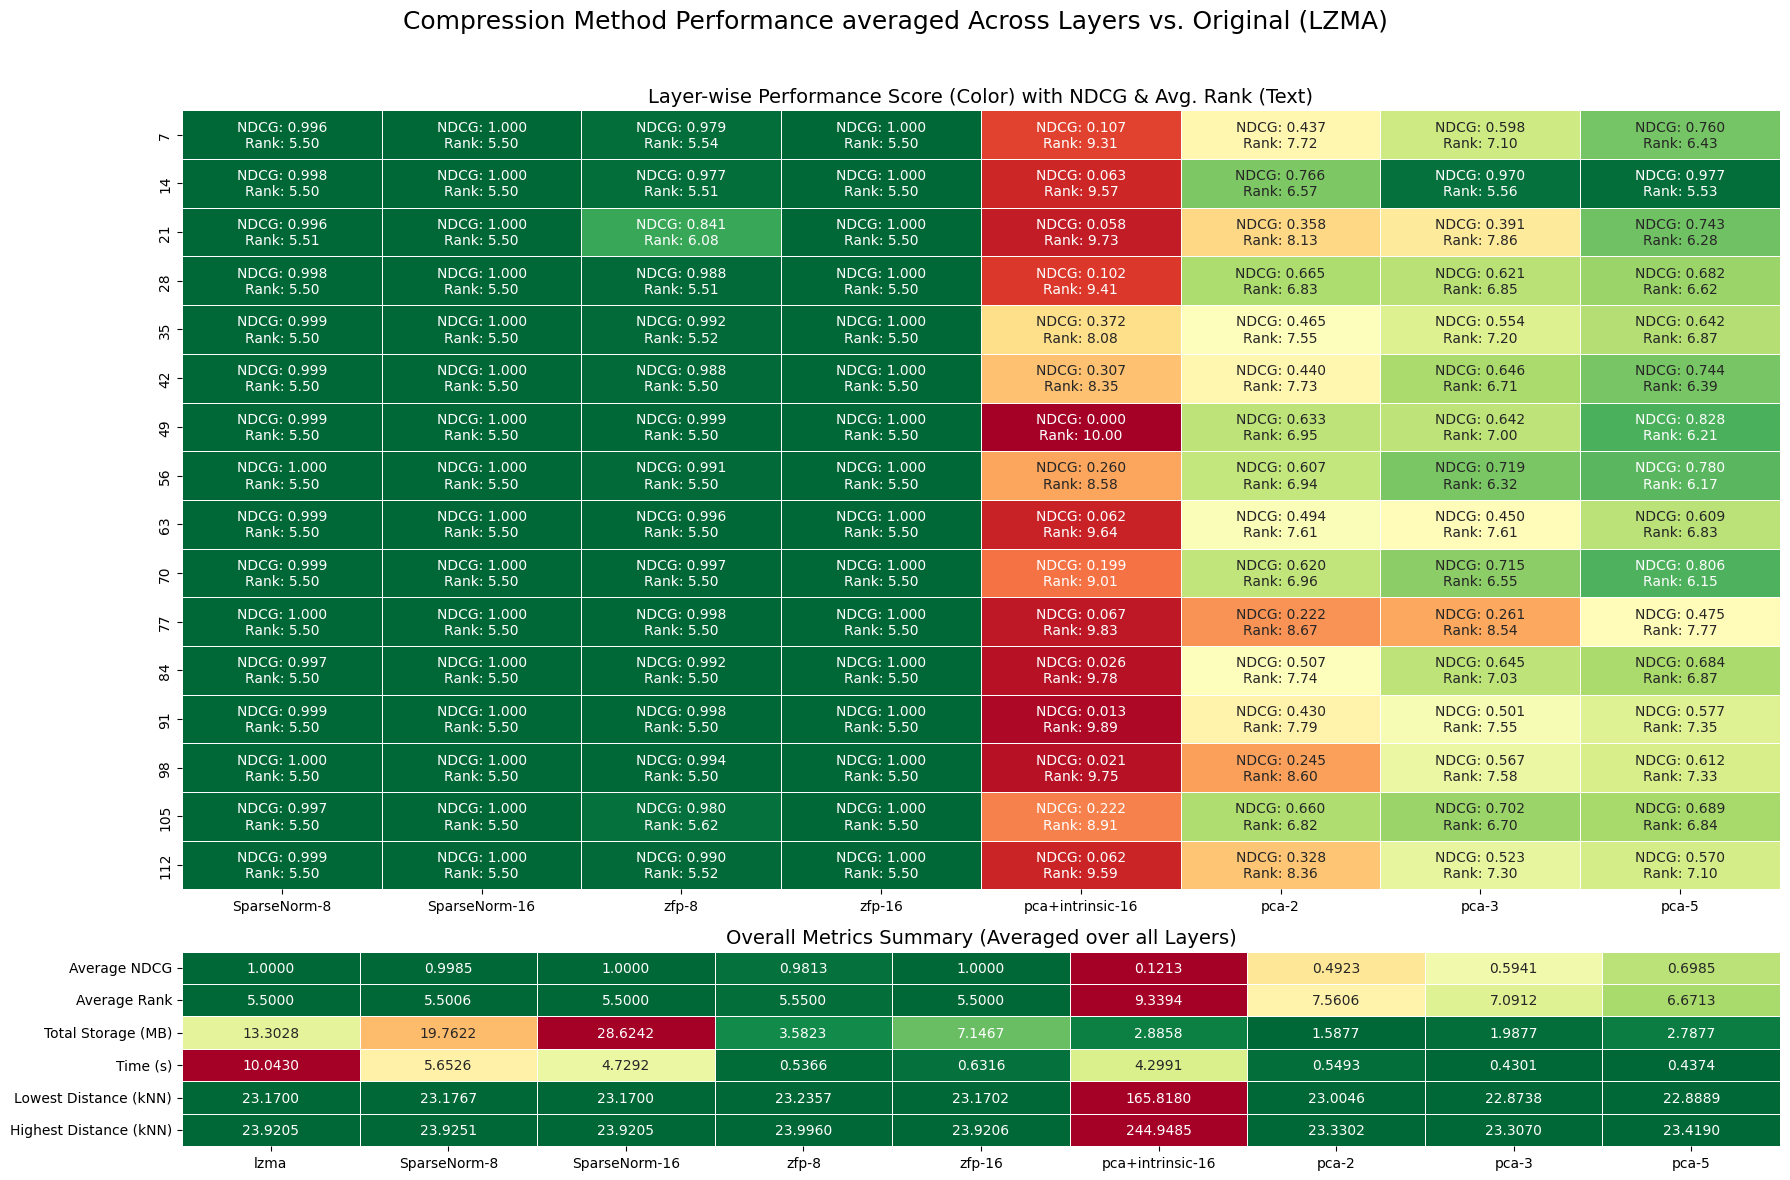

In [ ]:
# @title Visualization  { display-mode: "form" }

# --- Ranking Metric Calculation Functions (Unchanged) ---
def calculate_average_rank(ground_truth_indices, predicted_ranking, k=K_NEIGHBORS):
    if not ground_truth_indices or not predicted_ranking: return k
    rank_map = {sample_idx: rank + 1 for rank, sample_idx in enumerate(predicted_ranking)}
    return np.mean([rank_map.get(idx, len(predicted_ranking)) for idx in true_top_k]) if (true_top_k := ground_truth_indices[:k]) else k

def calculate_ndcg(ground_truth_indices, predicted_indices, k=K_NEIGHBORS):
    if not ground_truth_indices or not predicted_indices: return 0.0
    relevance_map = {idx: k - i for i, idx in enumerate(ground_truth_indices[:k])}
    dcg = sum(relevance_map.get(pred_idx, 0) / np.log2(i + 2) for i, pred_idx in enumerate(predicted_indices[:k]))
    idcg = sum(relevance_map.get(gt_idx, 0) / np.log2(i + 2) for i, gt_idx in enumerate(ground_truth_indices[:k]))
    return dcg / (idcg + 1e-9)

# --- Data Preparation ---
all_results = resultsArray
ground_truth_results = next((r for r in all_results if r["name"] == "lzma"), None)
if ground_truth_results:
    for layer_idx in relevantLayers:
        # Get the number of evaluation samples for this layer
        num_eval_samples = len(ground_truth_results["knn_per_layer"].get(layer_idx, []))

        for config in all_results:
            if config["name"] == "lzma": continue

            ndcg_scores, avg_rank_scores = [], []
            for i in range(num_eval_samples):
                # Get the ideal ranking for the i-th evaluation sample
                ideal_ranking = [item[0] for item in ground_truth_results["knn_per_layer"][layer_idx][i] if item[0] != -1]

                # Get the method's ranking for the i-th evaluation sample
                method_ranking = [item[0] for item in config["knn_per_layer"][layer_idx][i] if item[0] != -1]

                # Calculate metrics for this specific sample and store them
                ndcg_scores.append(calculate_ndcg(ideal_ranking, method_ranking))
                avg_rank_scores.append(calculate_average_rank(ideal_ranking, method_ranking))

            # Store the AVERAGE score across all evaluation samples for the layer
            config["ndcg"][layer_idx] = np.mean(ndcg_scores) if ndcg_scores else 0.0
            config["average_rank"][layer_idx] = np.mean(avg_rank_scores) if avg_rank_scores else K_NEIGHBORS

ndcg_data, avg_rank_data = {}, {}
for res in all_results:
    if res['name'] == 'lzma': continue
    ndcg_data[res['name']] = [res['ndcg'].get(l, 0.0) for l in relevantLayers]
    avg_rank_data[res['name']] = [res['average_rank'].get(l, K_NEIGHBORS) for l in relevantLayers]

ndcg_df = pd.DataFrame(ndcg_data, index=relevantLayers)
avg_rank_df = pd.DataFrame(avg_rank_data, index=relevantLayers)

# --- CHANGE: Create a Unified Performance Score using Min-Max Normalization ---
# 1. Normalize NDCG (higher is better)
min_ndcg, max_ndcg = ndcg_df.min().min(), ndcg_df.max().max()
ndcg_range = max_ndcg - min_ndcg
normalized_ndcg_df = (ndcg_df - min_ndcg) / ndcg_range if ndcg_range > 0 else pd.DataFrame(1.0, index=ndcg_df.index, columns=ndcg_df.columns)

# 2. Normalize Average Rank (lower is better, so we invert the scale)
min_rank, max_rank = avg_rank_df.min().min(), avg_rank_df.max().max()
rank_range = max_rank - min_rank
normalized_rank_df = (max_rank - avg_rank_df) / rank_range if rank_range > 0 else pd.DataFrame(1.0, index=avg_rank_df.index, columns=avg_rank_df.columns)

# 3. Average the two normalized scores with a 50/50 weight
combined_score_df = (normalized_ndcg_df + normalized_rank_df) / 2

# Create custom labels for the combined heatmap (Unchanged)
annot_labels = pd.DataFrame(index=ndcg_df.index, columns=ndcg_df.columns, dtype=str)
for col in ndcg_df.columns:
    for idx in ndcg_df.index:
        ndcg_val = ndcg_df.loc[idx, col]
        rank_val = avg_rank_df.loc[idx, col]
        annot_labels.loc[idx, col] = f"NDCG: {ndcg_val:.3f}\nRank: {rank_val:.2f}"

# Prepare the summary metrics table at the bottom (Unchanged)
metrics_data = {
    'Average NDCG': [
        # Correctly access the 'ndcg' key and calculate the mean of its values
        np.mean(list(res['ndcg'].values())) if res.get('ndcg') else 0
        for res in all_results
    ],
    'Average Rank': [
        # Correctly access the 'average_rank' key and calculate the mean of its values
        np.mean(list(res['average_rank'].values())) if res.get('average_rank') else 0
        for res in all_results
    ],
    'Total Storage (MB)': [res['storage'] / (1024 * 1024) for res in all_results],
    'Time (s)': [res['time'] for res in all_results],

    # --- FIX: Calculate the AVERAGE of all distances, not the min of lists ---
    'Lowest Distance (kNN)': [
        np.mean([dist for sublist in res['lowest_distance'].values() for dist in sublist if dist != float('inf')])
        if res.get('lowest_distance') else 0
        for res in all_results
    ],

    # --- FIX: Calculate the AVERAGE of all distances, not the max of lists ---
    'Highest Distance (kNN)': [
        np.mean([dist for sublist in res['highest_distance'].values() for dist in sublist if dist != 0.0])
        if res.get('highest_distance') else 0
        for res in all_results
    ]
}

# This will now work correctly
metrics_df = pd.DataFrame(metrics_data, index=[res['name'] for res in all_results]).T
metrics_annot = metrics_df.map(lambda x: f'{x:.4f}').values

# --- Plotting (Unchanged layout) ---
fig, axes = plt.subplots(2, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [16, 4]})
fig.suptitle('Compression Method Performance averaged Across Layers vs. Original (LZMA)', fontsize=18)

# --- Top Heatmap for Combined Score ---
sns.heatmap(
    combined_score_df,
    ax=axes[0],
    annot=annot_labels,
    fmt="s",
    cmap="RdYlGn",  # Use intuitive Red-Yellow-Green colormap
    linewidths=.5,
    vmin=0,
    vmax=1,
    cbar=False#_kws={'label': 'Combined Performance (Higher is Better)'}
)
axes[0].set_title('Layer-wise Performance Score (Color) with NDCG & Avg. Rank (Text)', fontsize=14)
axes[0].set_ylabel('', fontsize=12)
axes[0].set_xlabel('')

# --- Bottom Heatmap for Overall Metrics ---
# Normalize the summary data to apply a consistent and intuitive colormap
summary_norm_df = metrics_df.copy()
for metric in summary_norm_df.index:
    min_val, max_val = summary_norm_df.loc[metric].min(), summary_norm_df.loc[metric].max()
    if (max_val - min_val) > 1e-9:
        summary_norm_df.loc[metric] = (summary_norm_df.loc[metric] - min_val) / (max_val - min_val)
    else:
        summary_norm_df.loc[metric] = 0.5

# Invert colors for "lower-is-better" metrics so that green is always good
metrics_to_invert = ['Total Storage (MB)', 'Average Rank', 'Time (s)', 'Lowest Distance (kNN)', 'Highest Distance (kNN)']
for metric in metrics_to_invert:
    if metric in summary_norm_df.index:
        summary_norm_df.loc[metric] = 1 - summary_norm_df.loc[metric]

sns.heatmap(
    summary_norm_df,
    ax=axes[1],
    annot=metrics_annot, # Use original, un-normalized values for the text
    fmt='s',
    cmap="RdYlGn",
    cbar=False,
    linewidths=.5
)
axes[1].set_title('Overall Metrics Summary (Averaged over all Layers)', fontsize=14)
axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('')
plt.setp(axes[1].get_xticklabels(), ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()